In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
df = pd.read_csv('https://drive.google.com/file/d/1vqxpwQTbh80GILVhrm-id6efxcXjn3mu/view?usp=drive_link')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_program                       5865 non-null   int64  
 1   customer_id                      5865 non-null   int64  
 2   program_id                       5865 non-null   int64  
 3   promocode_id                     5864 non-null   float64
 4   paid                             5865 non-null   int64  
 5   paid_amount                      5865 non-null   float64
 6   delivery_start_date              5865 non-null   object 
 7   total_days                       5865 non-null   int64  
 8   free_days                        5865 non-null   int64  
 9   status                           5865 non-null   object 
 10  created_at_program               5865 non-null   object 
 11  diet_program_name                5865 non-null   object 
 12  master_plan_name    

In [3]:
# new features
# 1. Time-based features
df_enhanced = df.copy()
df_enhanced['subscription_season'] = pd.cut(
    df_enhanced['subscribe_month'], 
    bins=[0, 3, 6, 9, 12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)

df_enhanced['is_weekend'] = df_enhanced['subscribe_weekday'].isin(['Saturday', 'Sunday']).astype(int)

# 2. Customer age groups
df_enhanced['age_group'] = pd.cut(
    df_enhanced['age'], 
    bins=[0, 25, 35, 45, 55, 100], 
    labels=['18-25', '26-35', '36-45', '46-55', '55+']
)

# 3. BMI categories
df_enhanced['bmi_category'] = pd.cut(
    df_enhanced['bmi'], 
    bins=[0, 18.5, 25, 30, 100], 
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# 4. Program duration categories
df_enhanced['duration_category'] = pd.cut(
    df_enhanced['total_days'], 
    bins=[0, 7, 14, 30, 1000], 
    labels=['Short', 'Medium', 'Long', 'Extended']
)

# 5. Price categories
df_enhanced['price_category'] = pd.cut(
    df_enhanced['paid_amount'], 
    bins=[0, 100, 200, 500, 10000], 
    labels=['Low', 'Medium', 'High', 'Premium']
)

# 6. Interaction features
df_enhanced['age_bmi_interaction'] = df_enhanced['age'] * df_enhanced['bmi'] / 100
df_enhanced['weight_height_ratio'] = df_enhanced['weight'] / (df_enhanced['height'] / 100)
df_enhanced['price_per_day'] = df_enhanced['paid_amount'] / df_enhanced['total_days']

# 7. Customer engagement features
df_enhanced['days_since_birth'] = (df_enhanced['subscribe_year'] - df_enhanced['birth_year']) * 365
df_enhanced['customer_tenure'] = df_enhanced['subscribe_year'] - df_enhanced['created_year']

# 8. Program complexity features
df_enhanced['has_free_days'] = (df_enhanced['free_days'] > 0).astype(int)
df_enhanced['delivery_efficiency'] = df_enhanced['delivery_duration_days'] / df_enhanced['total_days']

new_features = set(df_enhanced.columns) - set(df.columns)

In [4]:
target = "program_id"

# Analyze class distribution
class_counts = df_enhanced[target].value_counts()
class_counts

program_id
5637170869    465
5637170867    418
5637177579    317
5637167080    281
5637180581    269
             ... 
5637179081      1
5637170078      1
5637176870      1
5637170886      1
5637180585      1
Name: count, Length: 196, dtype: int64

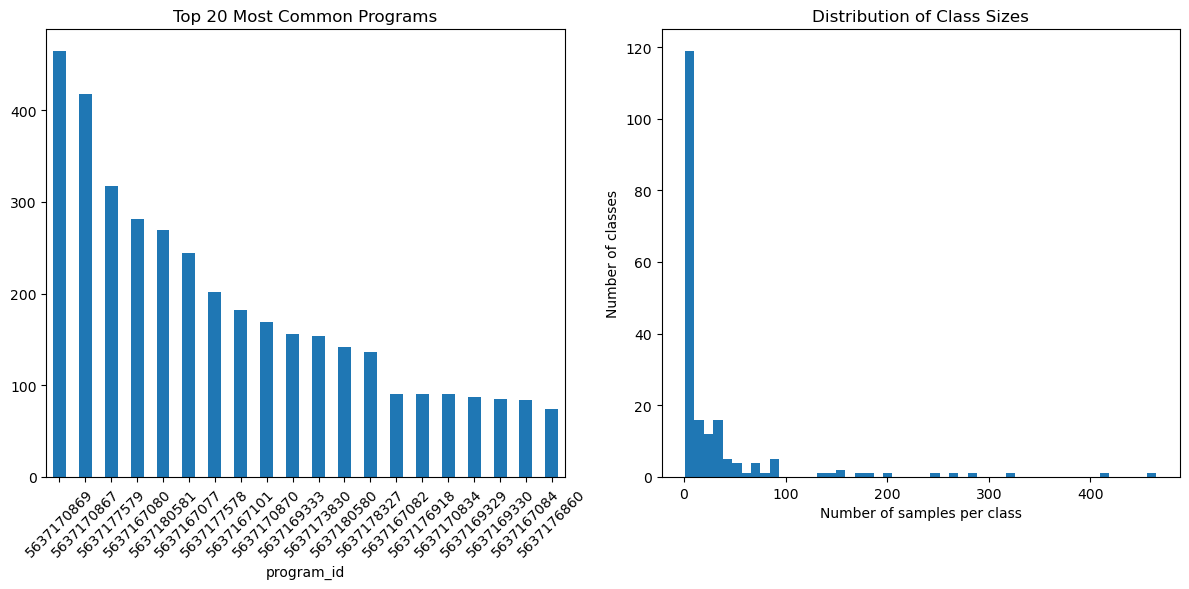

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.head(20).plot(kind='bar')
plt.title('Top 20 Most Common Programs')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(class_counts.values, bins=50)
plt.title('Distribution of Class Sizes')
plt.xlabel('Number of samples per class')
plt.ylabel('Number of classes')
plt.tight_layout()
plt.show()

In [6]:
# Calculate imbalance metrics
imbalance_ratio = class_counts.max() / class_counts.min()
imbalance_ratio

465.0

In [7]:
# Separate features and target
exclude_cols = [
    target, 'id_program', 'customer_id', 'promocode_id', 
    'created_at_program', 'delivery_start_date', 'created_at_customer', 
    'date_of_birth', 'deleted_at', 'created_month_year_str_program', 
    'created_month_year_str_customer', 'subscribe_month_name', 
    'created_month_year', 'diet_program_name', 'master_plan_name'
]

X = df_enhanced.drop(columns=exclude_cols)
y = df_enhanced[target]

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
display(numerical_features, categorical_features)

['paid',
 'paid_amount',
 'total_days',
 'free_days',
 'subscribe_year',
 'subscribe_month',
 'subscribe_day',
 'subscribe_quarter',
 'delivery_duration_days',
 'id_customer',
 'age',
 'height',
 'weight',
 'birth_year',
 'birth_month',
 'birth_day',
 'birth_quarter',
 'created_year',
 'created_month',
 'created_day',
 'created_quarter',
 'gender_encoded',
 'bmi',
 'is_weekend',
 'age_bmi_interaction',
 'weight_height_ratio',
 'price_per_day',
 'days_since_birth',
 'customer_tenure',
 'has_free_days',
 'delivery_efficiency']

['status',
 'subscribe_weekday',
 'username',
 'email',
 'nationality',
 'gender',
 'birth_weekday',
 'created_month_name',
 'created_weekday',
 'email_domain']

In [8]:
class_counts = y.value_counts()
# Filter out classes with insufficient samples for stratification
min_samples_for_stratification = 2
valid_classes = class_counts[class_counts >= min_samples_for_stratification].index
valid_classes

Index([5637170869, 5637170867, 5637177579, 5637167080, 5637180581, 5637167077,
       5637177578, 5637167101, 5637170870, 5637169333,
       ...
       5637170904, 5637167829, 5637170081, 5637170079, 5637169339, 5637170909,
       5637170905, 5637170887, 5637170906, 5637180589],
      dtype='int64', name='program_id', length=166)

In [9]:
# Filter data to only include classes with sufficient samples
mask = y.isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

In [11]:
train_class_counts = y_train.value_counts()

In [12]:
# Filter out classes with too few samples
min_samples_per_class = 5
valid_classes = train_class_counts[train_class_counts >= min_samples_per_class].index

In [13]:
# Filter training data
train_mask = y_train.isin(valid_classes)
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

In [14]:
# Check for infinity values
inf_count = np.isinf(X_train_filtered.select_dtypes(include=[np.number])).sum().sum()
inf_count

80

In [15]:
# Check for extreme values
numerical_cols = X_train_filtered.select_dtypes(include=[np.number]).columns
extreme_values = 0

for col in numerical_cols:
    Q1 = X_train_filtered[col].quantile(0.25)
    Q3 = X_train_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for more conservative outlier detection
    upper_bound = Q3 + 3 * IQR
    
    extreme_mask = (X_train_filtered[col] < lower_bound) | (X_train_filtered[col] > upper_bound)
    extreme_values += extreme_mask.sum()
    
    # Replace extreme values with bounds
    X_train_filtered.loc[extreme_mask, col] = X_train_filtered[col].median()

print(f"Extreme values replaced: {extreme_values}")

Extreme values replaced: 5108


In [16]:
# Replace infinity values with median
for col in numerical_cols:
    inf_mask = np.isinf(X_train_filtered[col])
    if inf_mask.any():
        X_train_filtered.loc[inf_mask, col] = X_train_filtered[col].median()

# Check for any remaining problematic values
remaining_inf = np.isinf(X_train_filtered.select_dtypes(include=[np.number])).sum().sum()
remaining_nan = X_train_filtered.isnull().sum().sum()

In [17]:
# Create a simple preprocessor for SMOTE
numerical_transformer_simple = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_simple = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Create preprocessor for SMOTE
preprocessor_smote = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer_simple, numerical_features),
        ("cat", categorical_transformer_simple, categorical_features)
    ],
    remainder='drop'
)

# Apply preprocessing to training data
X_train_processed_for_smote = preprocessor_smote.fit_transform(X_train_filtered)
X_train_processed_for_smote

<4500x4140 sparse matrix of type '<class 'numpy.float64'>'
	with 166500 stored elements in Compressed Sparse Row format>

In [18]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed_for_smote, y_train_filtered)

In [19]:
print(pd.Series(y_train_balanced).value_counts().head(10))

# Save the SMOTE preprocessor for later use
joblib.dump(preprocessor_smote, "smote_preprocessor.pkl")

program_id
5637169327    372
5637170884    372
5637173082    372
5637170859    372
5637174590    372
5637180579    372
5637167081    372
5637171577    372
5637172400    372
5637176859    372
Name: count, dtype: int64


['smote_preprocessor.pkl']

### PREPROCESSING PIPELINE

In [20]:
inf_count_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
inf_count_test

13

In [21]:
# Check for extreme values in test data
numerical_cols_test = X_test.select_dtypes(include=[np.number]).columns
extreme_values_test = 0

for col in numerical_cols_test:
    Q1 = X_test[col].quantile(0.25)
    Q3 = X_test[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    extreme_mask = (X_test[col] < lower_bound) | (X_test[col] > upper_bound)
    extreme_values_test += extreme_mask.sum()
    
    # Replace extreme values with bounds
    X_test.loc[extreme_mask, col] = X_test[col].median()
extreme_values_test

1323

In [22]:
for col in numerical_cols_test:
    inf_mask = np.isinf(X_test[col])
    if inf_mask.any():
        X_test.loc[inf_mask, col] = X_test[col].median()

# Check for any remaining problematic values in test data
remaining_inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
remaining_nan_test = X_test.isnull().sum().sum()
display(remaining_inf_test, remaining_nan_test)

0

1418

In [23]:
# Now apply preprocessing to cleaned test data
X_test_processed = preprocessor_smote.transform(X_test)

# Check for any problematic values in test data
# Convert sparse matrix to dense if needed for checking
if hasattr(X_test_processed, 'toarray'):
    X_test_processed_dense = X_test_processed.toarray()
else:
    X_test_processed_dense = X_test_processed

In [24]:
nan_count_test = np.isnan(X_test_processed_dense).sum()
inf_count_test = np.isinf(X_test_processed_dense).sum()

In [25]:
if nan_count_test > 0 or inf_count_test > 0:
    print("⚠️ Cleaning test data...")
    if hasattr(X_test_processed, 'toarray'):
        # Convert to dense, clean, then back to sparse
        X_test_processed_dense = np.nan_to_num(X_test_processed_dense, nan=0.0, posinf=0.0, neginf=0.0)
        from scipy.sparse import csr_matrix
        X_test_processed = csr_matrix(X_test_processed_dense)
    else:
        X_test_processed = np.nan_to_num(X_test_processed, nan=0.0, posinf=0.0, neginf=0.0)


In [26]:
# Create feature selector
feature_selector = SelectKBest(score_func=f_classif, k=100)

# Fit on training data and transform both
X_train_selected = feature_selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = feature_selector.transform(X_test_processed)

In [27]:
joblib.dump(feature_selector, "enhanced_feature_selector.pkl")

['enhanced_feature_selector.pkl']

# HYPERPARAMETER TUNING

In [28]:
# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],          
    'max_depth': [10, 20, None],          
    'min_samples_split': [2, 5],         
    'min_samples_leaf': [1, 2],          
    'max_features': ['sqrt', 'log2']     
}

# Grid search for Random Forest
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_selected, y_train_balanced)

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest score: {rf_grid_search.best_score_:.4f}")

best_rf = rf_grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Random Forest parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest score: 0.9536


In [ ]:
# Gradient Boosting parameter grid
gb_param_grid = {
    'n_estimators': [100, 200], 
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],        
    'subsample': [0.8, 1.0]     
}

# Grid search for Gradient Boosting
gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train_selected, y_train_balanced)

print(f"Best Gradient Boosting parameters: {gb_grid_search.best_params_}")
print(f"Best Gradient Boosting score: {gb_grid_search.best_score_:.4f}")

best_gb = gb_grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


# CREATE ENSEMBLE MODEL

In [ ]:
# Train additional models
svm_model = SVC(probability=True, random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train individual models
print("Training SVM...")
svm_model.fit(X_train_selected, y_train_balanced)

print("Training Logistic Regression...")
lr_model.fit(X_train_selected, y_train_balanced)

# Create voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('svm', svm_model),
        ('lr', lr_model)
    ],
    voting='soft'
)

# Train ensemble
print("Training ensemble model...")
voting_classifier.fit(X_train_selected, y_train_balanced)

In [ ]:
# Create models dictionary
models = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'SVM': svm_model,
    'Logistic Regression': lr_model,
    'Ensemble': voting_classifier
}

# Evaluate each model
results = {}
print("Model Performance Comparison:")
print("=" * 60)

for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'accuracy': accuracy, 'f1_score': f1}
    print(f"{name:20} | Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = models[best_model_name]

print(f"\n🏆 Best model: {best_model_name}")
print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")

In [ ]:
# Get predictions from best model
y_pred_final = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)

print(f"Final Model: {best_model_name}")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"F1-Score (Macro): {f1_score(y_test, y_pred_final, average='macro'):.4f}")

# Classification report for top classes
top_classes = y_test.value_counts().head(10).index
y_test_top = y_test[y_test.isin(top_classes)]
y_pred_top = y_pred_final[y_test.isin(top_classes)]

print("\nClassification Report (Top 10 Classes):")
print(classification_report(y_test_top, y_pred_top))